In [1]:
import torch
import numpy as np
import cv2
from PIL import Image

In [2]:
import sys
sys.path.append('..')
from models import resnet50, densenet_121, resnet50_adv, resnet18
from utils import *

In [3]:
# checkpoint_path = '../checkpoints/mwd_resnet50/fold_0_model_best.pth.tar'
checkpoint_path = '../checkpoints/my_data_resnet50/fold_0_model_best.pth.tar'
model = resnet50()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
checkpoint_path = '../checkpoints/my_data_densenet121/fold_0_model_best.pth.tar'
model = densenet_121()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
checkpoint_path = '../checkpoints/my_data_densenet121_norm/fold_0_model_best.pth.tar'
model = densenet_121()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
checkpoint_path = '../checkpoints/my_data_resnet50_cs/fold_0_model_best.pth.tar'
model = resnet50_adv()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
checkpoint_path = '../checkpoints/my_data_v3_resnet18/fold_0_model_best.pth.tar'
model = resnet18()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
checkpoint_path = '../checkpoints/my_data_v3_densenet121/01_14_21_27_fold_0_model_best.pth.tar'
model = densenet_121()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
checkpoint_path = '../checkpoints/my_data_densenet121_transfer/fold_0_model_best.pth.tar'
model = densenet_121()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
checkpoint_path = '../checkpoints/my_data_v3_densenet121_transfer/fold_0_model_best.pth.tar'
model = densenet_121()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# 加载真实路面数据集
from dataset import MWD, MWD_Adv
from dataset import MyData, MyDataCS
from torchvision import transforms
import matplotlib.pyplot as plt
import itertools

In [6]:
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

# dataset = MWD(root_path="G:\\weather_recognition\\groud_truth", transform=transform)
# dataset = MWD_Adv(root_path="G:\\weather_recognition\\groud_truth", transform=transform)

# train_dataset = MyData(root_path=args.train_path, transform=train_transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v2\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_01_11\\", transform=transform)
# dataset = MyDataCS(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_01_11\\", transform=transform)
dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v3\\test\\", transform=transform)

In [7]:
print(len(dataset))
print(dataset[0][0].shape)

5004
torch.Size([3, 224, 224])


In [8]:
# img, true label, pred label 可视化

label_dict = {'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5}
label_list = ['cloudy', 'haze', 'rainy', 'snow', 'sunny', 'thunder']
def show_model_performance(images, labels, outputs, batch_idx=0):
    # print(images.shape, labels.shape, outputs.shape)
    _, figs = plt.subplots(1, 32, figsize=(96, 96))
    # print(len(figs))
    for f, img, lbl, pred in zip(figs, images, labels, outputs):
        img = np.transpose(img, (1, 2, 0))
        f.imshow(img)
        # print(lbl, pred)
        f.set_title(label_list[lbl] + ';' + label_list[pred[0]])
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    
    fig = plt.gcf()
    fig.savefig('figs/show_performance_' + str(batch_idx) + '.png', format='png', transparent=True)

    plt.show()

In [9]:
# 绘制混淆矩阵

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def compute_cm(cm, preds, labels):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        # if t == 2 and p == 1:
        #     print('miss!')
        # cm[p, t] += 1
        cm[t, p] += 1
    return cm

In [10]:
cnt = 0
def save_misclassify(inputs, targets, preds):
    global cnt
    save_dir = "misclassify_01_15_v3_densnet121_transfer//"
    label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for img, t, p in zip(inputs, targets, preds):
        p = p[0]
        # print(img.shape, t, p)
        # break
        if t != p:
            img = np.transpose(img, (1, 2, 0))
            img = img * 255
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            # print(img.shape)
            img_path = save_dir + '{0}_{1}_{2}.jpg'.format(cnt, label_list[t], label_list[p]) 
            cv2.imwrite(img_path, img)
            cnt = cnt + 1


72.28217426059153
[[4.340e+02 1.500e+01 3.700e+01 1.700e+02 2.910e+02 0.000e+00]
 [2.000e+00 5.300e+01 3.300e+01 0.000e+00 0.000e+00 4.500e+01]
 [7.700e+01 1.100e+01 4.960e+02 1.000e+00 2.600e+01 1.000e+00]
 [1.000e+00 0.000e+00 4.500e+01 9.000e+01 1.000e+02 1.200e+01]
 [3.790e+02 8.300e+01 1.400e+01 3.200e+01 2.296e+03 9.000e+00]
 [0.000e+00 0.000e+00 2.000e+00 0.000e+00 1.000e+00 2.480e+02]]
Normalized confusion matrix
[[0.45828933 0.01583949 0.03907075 0.17951426 0.30728617 0.        ]
 [0.01503759 0.39849624 0.2481203  0.         0.         0.33834586]
 [0.12581699 0.01797386 0.81045752 0.00163399 0.04248366 0.00163399]
 [0.00403226 0.         0.18145161 0.36290323 0.40322581 0.0483871 ]
 [0.1347316  0.02950587 0.00497689 0.01137576 0.81621045 0.00319943]
 [0.         0.         0.00796813 0.         0.00398406 0.98804781]]


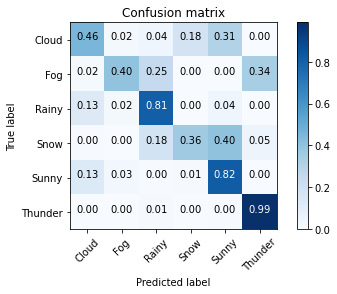

In [11]:
# 'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5
model = model.cuda()
model.eval()
top1 = AverageMeter()
data_iter = torch.utils.data.DataLoader(dataset, 16, shuffle=False)

# 混淆矩阵
num_classes = 6
label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']
confuse_matrix = np.zeros([num_classes, num_classes])
for batch_idx, (inputs, targets) in enumerate(data_iter):
    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)

    # print(outputs)
    _, pred = outputs.topk(1, 1)
    # print(pred)
    # print(targets)
    confuse_matrix = compute_cm(confuse_matrix, outputs, targets)
    prec = accuracy(outputs.data, targets.data, topk=(1,))
    top1.update(prec[0].item(), inputs.size(0))
    # save_misclassify(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
    # break
print(top1.avg)
print(confuse_matrix)
plot_confusion_matrix(confuse_matrix, label_list, normalize=True)
    # show_model_performance(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy(), batch_idx)
    # break

59.01323042998897
[[ 287.   56.    8.  140.  388.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.]
 [  12.    0.    5.  107.   24.    0.]
 [ 735.    4.   27.   39. 1747.   49.]
 [   0.    0.    0.    0.    0.    0.]]
Normalized confusion matrix
[[0.32650739 0.06370876 0.00910125 0.1592719  0.44141069 0.        ]
 [       nan        nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan]
 [0.08108108 0.         0.03378378 0.72297297 0.16216216 0.        ]
 [0.28258362 0.00153787 0.01038062 0.01499423 0.67166474 0.01883891]
 [       nan        nan        nan        nan        nan        nan]]


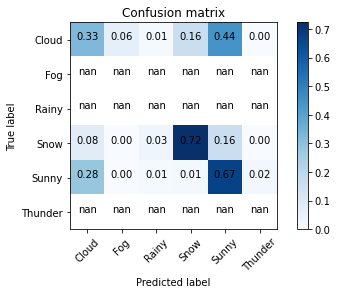

In [10]:
# 'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5
model = model.cuda()
model.eval()
top1 = AverageMeter()
data_iter = torch.utils.data.DataLoader(dataset, 16, shuffle=False)

# 混淆矩阵
num_classes = 6
label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']
confuse_matrix = np.zeros([num_classes, num_classes])
for batch_idx, (inputs, targets, constrast, hist) in enumerate(data_iter):
    inputs, targets, constrast, hist = inputs.cuda(), targets.cuda(), constrast.cuda(), hist.cuda()

    outputs = model(inputs, constrast, hist)

    # print(outputs)
    _, pred = outputs.topk(1, 1)
    # print(pred)
    # print(targets)
    confuse_matrix = compute_cm(confuse_matrix, outputs, targets)
    prec = accuracy(outputs.data, targets.data, topk=(1,))
    top1.update(prec[0].item(), inputs.size(0))
    # save_misclassify(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
    # break
print(top1.avg)
print(confuse_matrix)
plot_confusion_matrix(confuse_matrix, label_list, normalize=True)
    # show_model_performance(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy(), batch_idx)
    # break

Normalized confusion matrix
[[0.24604013 0.19112988 0.00422386 0.11826822 0.43928194 0.00105597]
 [0.2556391  0.7443609  0.         0.         0.         0.        ]
 [0.35620915 0.00163399 0.49346405 0.         0.14869281 0.        ]
 [0.         0.         0.09274194 0.50403226 0.40322581 0.        ]
 [0.31603271 0.01528617 0.01564166 0.         0.651262   0.00177746]
 [0.         0.01992032 0.00796813 0.00398406 0.03187251 0.93625498]]


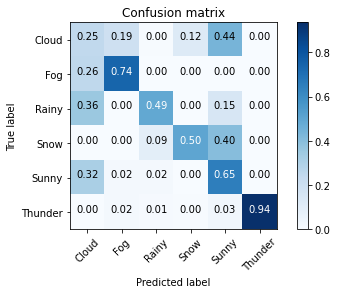

In [11]:
plot_confusion_matrix(confuse_matrix, label_list, normalize=True)

In [14]:
checkpoint_path


'../checkpoints/my_data_v3_densenet121/01_14_21_27_fold_0_model_best.pth.tar'